In [68]:
import qtensor
import xarray as xar
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append('../data/generators/')
import miplog_helper

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
def to_mh(item) -> miplog_helper.MiplogData:
    starts, *diffs = item
    return miplog_helper.MiplogData.from_start_and_diffs(starts, diffs)

#a# Gurobi performance for different approximation ratio
### Read data

In [211]:
data_match = pickle.load(open('../data/gurobi_match.pkl', 'rb'))
data_opt = xar.open_dataarray('../data/gurobi_opt_threads1.nc')
quantum_data = xar.open_dataarray('../data/quantum_nsamples1000_d3.nc')

In [212]:
data_match.coords

Coordinates:
  * N        (N) int64 30 100 150 432 716 ... 33750 40000 50000 75000 100000
  * seed     (seed) int64 10 11 12 13 14 15 16 17 18 ... 52 53 54 55 56 57 58 59

In [213]:
data_opt.coords

Coordinates:
  * N        (N) int32 10 26 42 58 74 90 106 122 ... 346 362 378 394 410 426 442
  * seeds    (seeds) int32 10 11 12 13 14

In [214]:
quantum_data.coords

Coordinates:
  * N        (N) int32 30 100 150 432 716 ... 33750 40000 50000 75000 100000
  * p        (p) int32 3 6 8 12 14 16 18 20 32
  * types    (types) object 'transport' 'destructive'

In [215]:
def get_colors(n, cm=plt.cm.gnuplot2, offset=0.2):
    return [cm(offset + x*(1-2*offset)) for x in np.linspace(0, 1, n)]

In [216]:
def approx_ratio(p):
    try:
        AR = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']
        if AR>0:
            return AR
        else:
            raise KeyError
    except KeyError:
        AR = 1 - (0.3-np.log2(p)*0.05)
    return AR

def get_data_AR_lower(data, AR, nan_repl=None):
    times =  xar.apply_ufunc(lambda x: to_mh(x).get_time_for_AR_lower(AR)[0], data, vectorize=True)
    ftimes = times.astype(np.float)
    ftimes.data[np.isnan(ftimes.data)] = nan_repl or np.nan
    return ftimes

def get_data_AR_upper(data, AR, nan_repl=None):
    times =  xar.apply_ufunc(lambda x: to_mh(x).get_time_for_AR_upper(AR)[0], data, vectorize=True)
    ftimes = times.astype(np.float)
    ftimes.data[np.isnan(ftimes.data)] = nan_repl or np.nan
    return ftimes

In [77]:
approx_ratio(60)

0.995344529780426

AR is 0.8498938819897202
AR is 0.8792481250360578
AR is 0.9292481250360578


/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


Average is over 50 seeds


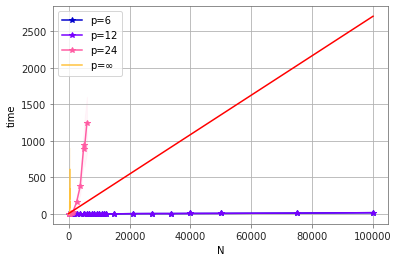

In [190]:
Ps = [6, 12, 24]
colors = iter(get_colors(len(Ps)+1))
for p in Ps:
    AR = approx_ratio(p)
    print('AR is', AR)
    data_p = get_data_AR_lower(data_match, AR, nan_repl=np.inf)
    av = data_p.median('seed')
    std = data_p.std('seed')
    mi = data_p.min('seed')
    mx = data_p.max('seed')
    color = next(colors)
    plt.plot(av.N, av,  '*-', color=color, label=f'p={int(p)}')
    #plt.fill_between(av.N, av+std, av-std, alpha=0.1, color=color)
    up = np.percentile(data_p, 85, axis=-1)
    dn = np.percentile(data_p, 15, axis=-1)
    plt.fill_between(av.N, dn, up, alpha=0.05, color=color)
    
color = next(colors)
plt.plot(data_opt.N, data_opt.mean('seeds'), color=color, label=r'p=$\infty$')
plt.fill_between(data_opt.N,
                 data_opt.min('seeds'),
                 data_opt.max('seeds'),
                 alpha=0.1,
                 color=color)
plt.xlabel('N')
plt.ylabel('time')
#plt.legend(loc='upper right')
plt.legend()
print(f'Average is over {len(data_match.seed)} seeds')
plt.plot(quantum_data.N, quantum_data.sel(p=12, types='transport'), color='red')
plt.grid()
plt.savefig('./pdf/gurobi_match_time_vs_p.pdf')

### Quantum quality vs n samples


Ratio at 20 samples 0.9940675829051888


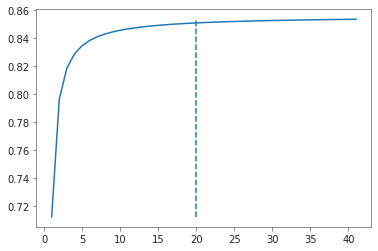

In [217]:
def quantum_lower_bound(AR, N_samples, conf=.5):
    return (1-(1-AR)*(1-conf)**(-1/N_samples))

q_reps = [int(1.1**x) for x in range(1, 40)]
AR = .856
conf = .5
ksi_min_up = [quantum_lower_bound(AR, N, conf=conf) for N in q_reps]
plt.plot(q_reps, ksi_min_up)
select_samples = 20
ratio_select = quantum_lower_bound(AR, select_samples, conf)/AR 
plt.vlines(select_samples, min(ksi_min_up), max(ksi_min_up), linestyle='--')
print(f'Ratio at {select_samples} samples', ratio_select)


### A log-log plot

AR p 6 0.8446004011699628
AR p 12 0.8749898193617508
AR p 14 0.8865015730186397
11.050772547721863
AR p 18 0.9052693772997084
AR p 20 0.9131375508476606
Average is over 50 seeds
<xarray.DataArray ()>
array(13.48756)
Coordinates:
    N        int32 21250
    p        int32 14
    types    <U9 'transport'


/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


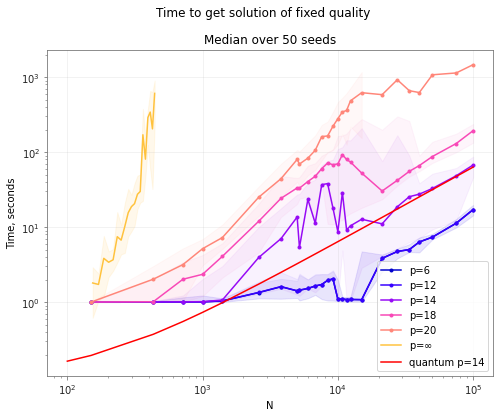

In [287]:
Ps = [6, 12, 14, 18, 20]
N_samples = 20
plt.figure(figsize=(8,6))

colors = iter(get_colors(len(Ps)+1))
for p in Ps:
    AR = approx_ratio(p)
    AR = quantum_lower_bound(AR, N_samples, conf=.5)
    print('AR p', p, AR)
    data_p = get_data_AR_lower(data_match, AR, nan_repl=np.inf)
    if p==14:
        print(np.median(data_p.sel(N=21250)))
    av = data_p.median('seed')
    std = data_p.std('seed')
    mi = data_p.min('seed')
    mx = data_p.max('seed')
    color = next(colors)
    plt.plot(av.N, av.where(av.N>100), '.-', color=color, label=f'p={p}')
    #plt.fill_between(av.N, av+std, av-std, alpha=0.1, color=color)
    #plt.fill_between(av.N, mi, mx, alpha=0.05, color=color)
    up = np.percentile(data_p.where(data_p.N>100), 90, axis=-1)
    dn = np.percentile(data_p.where(data_p.N>100), 10, axis=-1)
    plt.fill_between(av.N, dn, up, alpha=0.05, color=color)
    
color = next(colors)
data_opt_sub = data_opt.where(data_opt.N>10+32*4)
# -- Gurobi optimal
plt.plot(data_opt.N, data_opt_sub.mean('seeds'), color=color, label=r'p=$\infty$')
plt.fill_between(data_opt_sub.N,
                data_opt_sub.min('seeds'),
                data_opt_sub.max('seeds'),
                alpha=0.1,
                color=color)
plt.xlabel('N')
plt.ylabel('Time, seconds')

print(f'Average is over {len(data_match.seed)} seeds')
# -- quantum data
quantum_sub_data = quantum_data.where(quantum_data.N>30)
quantum_sub_data = quantum_sub_data.where(quantum_sub_data.N<=2e5)

p = 14
plt.plot(quantum_sub_data.N,
         quantum_sub_data.sel(p=p, types='transport')/1000*N_samples,
         color='red',
         label=f'quantum p={p}')
Nclose = quantum_sub_data.N[np.abs(quantum_sub_data.N-21250).argmin()]
print(quantum_sub_data.sel(N=Nclose, p=p, types='transport')/1000*N_samples)

#plt.ylim(.8, 1200)
#plt.xlim(100, max(data_match.N)*1.15)
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=.2)
plt.legend()
plt.suptitle('Time to get solution of fixed quality')
plt.title(f'Median over {len(data_match.seed)} seeds')
plt.savefig('./pdf/gurobi_match_time_vs_p_loglog.pdf')

### Upper bound


In [220]:
approx_ratio(55)

0.989067985676233

/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


Average is over 50 seeds


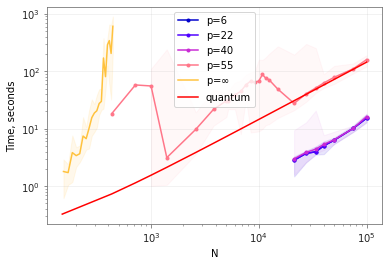

In [221]:
Ps = [ 6, 22, 40, 55]

colors = iter(get_colors(len(Ps)+1))
for p in Ps:
    data_p = get_data_AR_upper(data_match, approx_ratio(p), nan_repl=np.inf)
    av = data_p.median('seed')
    std = data_p.std('seed')
    mi = data_p.min('seed')
    mx = data_p.max('seed')
    color = next(colors)
    plt.plot(av.N, av.where(av.N>100), '.-', color=color, label=f'p={int(p)}')
    #plt.fill_between(av.N, av+std, av-std, alpha=0.1, color=color)
    #plt.fill_between(av.N, mi, mx, alpha=0.05, color=color)
    up = np.percentile(data_p.where(data_p.N>100), 90, axis=-1)
    dn = np.percentile(data_p.where(data_p.N>100), 10, axis=-1)
    plt.fill_between(av.N, dn, up, alpha=0.05, color=color)
    
color = next(colors)
data_opt_sub = data_opt.where(data_opt.N>10+32*4)
plt.plot(data_opt.N, data_opt_sub.mean('seeds'), color=color, label=r'p=$\infty$')
plt.fill_between(data_opt_sub.N,
                 data_opt_sub.min('seeds'),
                 data_opt_sub.max('seeds'),
                 alpha=0.1,
                 color=color)
plt.xlabel('N')
plt.ylabel('Time, seconds')
#plt.legend(loc='upper right')
print(f'Average is over {len(data_match.seed)} seeds')
quantum_sub_data = quantum_data.where(quantum_data.N>10+32*4)

plt.plot(quantum_sub_data.N,
         quantum_sub_data.sel(p=32, types='transport')/1000*N_samples, color='red',
         label='quantum')
#plt.ylim(.8, 1200)
#plt.xlim(100, max(data_match.N)*1.15)
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=.2)
plt.legend()
plt.savefig('./pdf/gurobi_match_time_vs_p_upper.pdf')

## A plot of gurobi perf at select poinst

In [222]:
data_match.N

<xarray.DataArray 'N' (N: 28)>
array([    30,    100,    150,    432,    716,   1000,   1400,   2600,   3800,
         5000,   5200,   6000,   6800,   7600,   8400,   9200,  10000,  10800,
        11600,  12400,  15000,  21250,  27500,  33750,  40000,  50000,  75000,
       100000])
Coordinates:
  * N        (N) int64 30 100 150 432 716 ... 33750 40000 50000 75000 100000

N=12400 Time to get AR bound 0.8953445297804259 for p=15 is 43.038851499557495
N=15000 Time to get AR bound 0.8953445297804259 for p=15 is 64.2079975605011


<ipython-input-196-62cb94ae3066>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 600)
<ipython-input-196-62cb94ae3066>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 600)


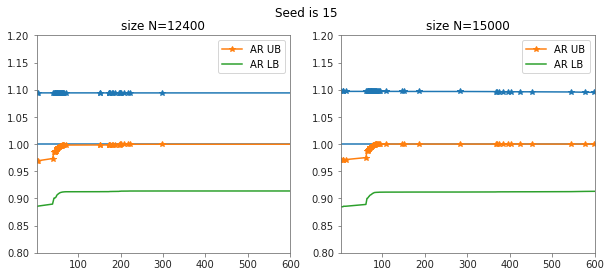

In [196]:
select_N = [12400, 15000]
select_p = 15
nfigs = len(select_N)

fig, axs = plt.subplots(1, nfigs, figsize=(5*nfigs, 4))
seed = 15
plt.suptitle(f'Seed is {seed}')
for i in range(nfigs):
    N = select_N[i]
    ax = axs[i] # only for single row layout
    plt.sca(ax)
    mh = to_mh(data_match.sel(seed=seed, N=N).data.item())
    AR = approx_ratio(select_p)
    print(f'N={N} Time to get AR bound {AR} for p={select_p} is {mh.get_time_for_AR_lower(AR)[0]}')
    mh.plot()
    plt.ylim(0.8, 1.20)
    plt.xlim(0, 600)
    plt.title(f'size N={N}')
    plt.xscale('linear')
    
    
    

### Times distributions over seeds for select N

N=9200 Median Time to get AR bound 0.8792481250360578 for p=12 is 2.1079764366149902
len 50
N=10000 Median Time to get AR bound 0.8792481250360578 for p=12 is 1.0981876850128174
len 50


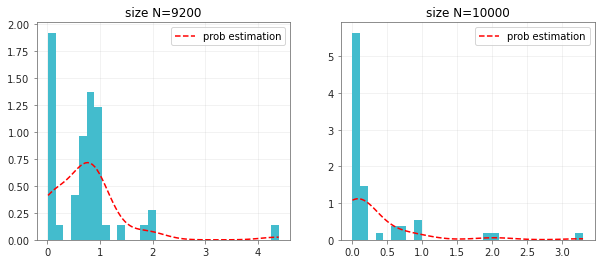

In [223]:
import scipy
select_N = [9200, 10000]
select_p = 12
nfigs = len(select_N)
plt.rcParams["axes.edgecolor"] = "0.45"
plt.rcParams["xtick.color"] = "0.45"
plt.rcParams["ytick.color"] = "0.45"
plt.rcParams["xtick.labelcolor"] = "0.15"
plt.rcParams["ytick.labelcolor"] = "0.15"


fig, axs = plt.subplots(1, nfigs, figsize=(5*nfigs, 4))
for i in range(nfigs):
    N = select_N[i]
    ax = axs[i] # only for single row layout
    plt.sca(ax)
    
    AR = approx_ratio(select_p)
    data_p = get_data_AR_lower(data_match.sel(N=N), AR)
    data_p = data_p.astype(np.float)
    data_p_clean = np.log(data_p[~np.isnan(data_p)])
    plt.hist(data_p_clean, bins=30, density=True, color='#43bccd', zorder=2)
    plt.grid(alpha=.2, zorder=0)
    print(f'N={N} Median Time to get AR bound {AR} for p={select_p} is {np.median(data_p)}')
    plt.title(f'size N={N}')
    
    # KDE
    kde = scipy.stats.gaussian_kde(data_p_clean)
    x = np.linspace(min(data_p_clean), max(data_p_clean), 100)
    print('len', len(data_p_clean))
    plt.plot(x, kde(x), '--', color='red', label='prob estimation')
    plt.legend(loc='upper right')
    
    
    

## Gap plot

In [224]:

data_match_mh = xar.apply_ufunc(to_mh, data_match, vectorize=True)
data_match_mh.N

<xarray.DataArray 'N' (N: 28)>
array([    30,    100,    150,    432,    716,   1000,   1400,   2600,   3800,
         5000,   5200,   6000,   6800,   7600,   8400,   9200,  10000,  10800,
        11600,  12400,  15000,  21250,  27500,  33750,  40000,  50000,  75000,
       100000])
Coordinates:
  * N        (N) int64 30 100 150 432 716 ... 33750 40000 50000 75000 100000

N=10000 best gap is 0.08398260796483745
N=12400 best gap is 0.08782690048671427
N=21250 best gap is 0.0935822076996185


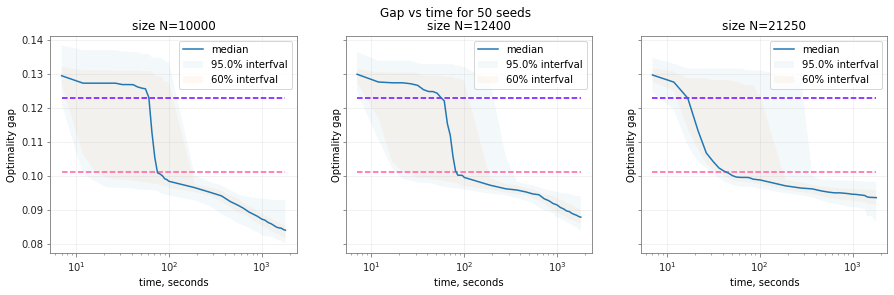

In [225]:

    

def plot_hist(select_N, get_val, data_match):
    nfigs = len(select_N)
    plt.rcParams["axes.edgecolor"] = "0.45"
    plt.rcParams["xtick.color"] = "0.45"
    plt.rcParams["ytick.color"] = "0.45"
    plt.rcParams["xtick.labelcolor"] = "0.15"
    plt.rcParams["ytick.labelcolor"] = "0.15"


    times = np.concatenate([
        np.linspace(7, 100, 20)
        ,np.linspace(100, 1800, 20)
    ])

    fig, axs = plt.subplots(1, nfigs, figsize=(5*nfigs, 4), sharey='row')
    for i in range(nfigs):
        N = select_N[i]
        try: 
            ax = axs[i] # only for single row layout
        except:
            ax = axs
        plt.sca(ax)

        gaps = []
        for ts in times:
            at_time = []
            for seed in data_match.seed:
                mh = data_match.sel(seed=seed, N=N).data.item()
                value = get_val(mh, ts)
                at_time.append(value)
            gaps.append(at_time)
            
        # debt
        """
        vals_rev = np.linspace(np.array(gaps).min(), np.array(gaps).max(), 30)
        times_rev = []
        for val in vals_rev:
            for_val = []
            for seed in data_match.seed:
                mh = data_match.sel(seed=seed, N=N).data.item()
                time_rev, ar = mh.get_time_for_AR_lower(val)
                if time_rev is None:
                    time_rev = np.inf
                for_val.append(time_rev)
            times_rev.append(for_val)
        select_AR = approx_ratio(p=18)
        for_val = []
        for seed in data_match.seed:
            mh = data_match.sel(seed=seed, N=N).data.item()
            time_rev, ar = mh.get_time_for_AR_lower(select_AR)
            if time_rev is None:
                time_rev = np.inf
            for_val.append(time_rev)
        print(f'N={N} time to get {select_AR} time = {np.median(for_val)}')
        
        av_tms = np.median(times_rev, -1)
        plt.plot(av_tms, vals_rev, '-*', label=f'rev median')
        """
                
        

        av = np.median(gaps, -1)
        plt.plot(times, av, '-', label=f'median')

        shift = 2.5
        up = np.percentile(gaps, 100-shift, axis=-1)
        dn = np.percentile(gaps, shift, axis=-1)
        plt.fill_between(times, dn, up, alpha=0.05, label=f'{100-2*shift}% interfval')

        shift = 20
        up = np.percentile(gaps, 100-shift, axis=-1)
        dn = np.percentile(gaps, shift, axis=-1)
        plt.fill_between(times, dn, up, alpha=0.05, label=f'{100-2*shift}% interfval')

        plt.grid(alpha=.2, zorder=0)
        print(f'N={N} best gap is {av[-1]}')
        plt.title(f'size N={N}')

        plt.legend()
        plt.xlabel('time, seconds')
        plt.ylabel('Optimality gap')
        plt.xscale('log')
        colors = get_colors(4)
        plt.hlines(0.101, xmin=min(times), xmax=max(times), linestyles='--', color=colors[2] )
        plt.hlines(0.123, xmin=min(times), xmax=max(times), linestyles='--', color=colors[1] )
    plt.suptitle(f'Gap vs time for {len(data_match.seed)} seeds')

    
def get_opt_gap(mh, ts):
    up, low = mh.get_bounds_at(ts)
    return (up-low)/low

def get_lb(mh, ts):
    up, low = mh.get_bounds_at(ts)
    if (up is None) or (low is None):
        return None
    return low/up

def get_ub(mh, ts):
    up, low = mh.get_bounds_at(ts)
    up, low2 = mh.get_bounds_at(np.inf)
    return low/low2
    
select_N = [10000, 12400, 21250]
plot_hist(select_N, get_opt_gap, data_match_mh)


## AR vs time plot

N_sampl 20
p 14
0.8865015730186397
red q 6.40006
0.8865015730186397
av [0.88478848 0.88708118 0.88708118 0.88708118 0.88708118 0.88730704
 0.88740706 0.88743289 0.88769963 0.8881998  0.88839241 0.8904337
 0.8980058  0.9047741  0.90837554 0.90864535 0.90908177 0.90980327
 0.91000331 0.91041242 0.91041242 0.91197066 0.91312622 0.91399218
 0.91537895 0.91623388 0.91706106 0.91796284 0.91855039 0.9190796
 0.91971613 0.92002017 0.92059486 0.92090186 0.92133885 0.92174499
 0.92194341 0.92200565 0.92234513 0.92252403]
N=10000.0 best gap is 0.922524027608453
[0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 1750.0]
N_sampl 20
p 14
0.8865015730186397
red q 13.487559999999998
0.8865015730186397
av [0.8848     0.88592941 0.88826492 0.89592157 0.90282353 0.9052549
 0.90633725 0.90785882 0.9083451  0.90887843 0.90938039 0.90944314
 0.90947451 0.90947451 0.9094902  0.90967276 0.90991231 0.90995655
 0.91003639 0.91006777 0.91006777 0.91152525 0.91207567 0.91227547
 0.91276042 0.91306258 0.91324674 0

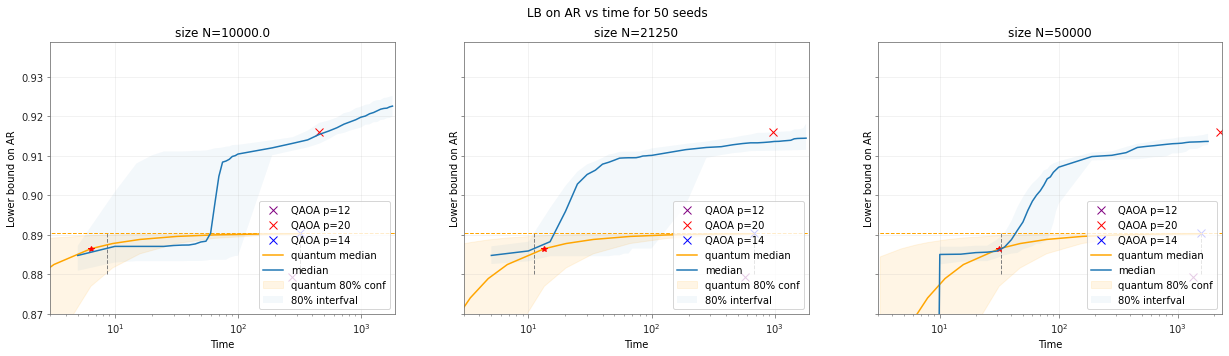

In [226]:
    
select_p = [12, 20, 14]
select_N = [1e4, 21250, 50000]

nfigs = len(select_N)

times = np.concatenate([
    np.linspace(5, 100, 20)
    , np.linspace(100, 1800, 20)
])

fig, axs = plt.subplots(1, nfigs, figsize=(7*nfigs, 5), sharey='row')
for i in range(nfigs):
    # -- Handle axes: case where 1 axis and many
    N = select_N[i]
    try: 
        ax = axs[i] # only for single row layout
    except:
        ax = axs
    plt.sca(ax)
    # --
    

    # -- Plot quantum guarantees for 1000 iterations
    colors=iter(['purple', 'red', 'blue'])
    for p in select_p:
        AR = approx_ratio(p)
        quants = quantum_data.sel(p=p, types='transport')
        time_q = quants[np.abs(quants.N - N).argmin()].data.item()
        plt.plot(time_q, AR, 'x', label=f'QAOA p={p}', color=next(colors), markersize=8)
    # --
        
    # -- Demonstrate special case for the _last_ p
    p = p
    time_q = time_q
    AR = approx_ratio(p)
    print('N_sampl', N_samples)
    print('p', p)
    
    q_reps = [2, 3, 4, 5, 7, 10, 20, 30, 50, 100, 200, 500, 1000]
    q_times = [time_q*x/1000 for x in q_reps]
    p_fail = 0.5
    ksi_min = [1-(1-AR)*(p_fail)**(-1/N) for N in q_reps]
    plt.plot(q_times, ksi_min, color='orange', label='quantum median')
    print(quantum_lower_bound(AR, N_samples, p_fail))
    plt.plot(time_q*N_samples/1000, quantum_lower_bound(AR, N_samples, p_fail), '*', color='red')
    print('red q', time_q/1000*N_samples)
    
    conf = 0.1
    ksi_min_low = [1-(1-AR)*(conf)**(-1/N) for N in q_reps]
    ksi_min_up = [1-(1-AR)*(1-conf)**(-1/N) for N in q_reps]
    plt.fill_between(q_times, ksi_min_low, ksi_min_up, alpha=0.1,
                     color='orange', label='quantum 80% conf')
    # --
    
    # -- calculate Classical match time
    times_ar = []
    AR_adj = quantum_lower_bound(AR, N_samples, p_fail)
    print(AR_adj)
    for seed in data_match_mh.seed:
        mh = data_match_mh.sel(seed=seed, N=N).data.item()
        t, _ = mh.get_time_for_AR_lower(AR_adj)
        if t is None:
            t=np.inf
        times_ar.append(t)
    time_g = np.median(times_ar)
    # --
    
    # depbt
    """
    ratios = np.linspace(.88, .92, 20)
    times_rat = []
    for ar in ratios:
        times_ar = []
        for seed in data_match_mh.seed:
            mh = data_match_mh.sel(seed=seed, N=N).data.item()
            t, _ = mh.get_time_for_AR_lower(ar)
            if t is None:
                t=np.inf
            times_ar.append(t)
        times_rat.append(times_ar)
    plt.plot(np.median(times_rat, -1), ratios, '*', color='black')
    """
    
    # -- Nice vertical lines
    plt.vlines(time_g, 0.88, AR, linestyle='--', color='gray', linewidth=1)
    plt.vlines(time_q, 0.88, AR, linestyle='--', color='gray', linewidth=1)
        
    
    # -- Handle gurobi match
    # ---- Calculate lower bound for various times
    gaps = []
    for ts in times:
        at_time = []
        for x in data_match_mh.sel(N=N):
            mh = x.item()
            value = get_lb(mh, ts)
            at_time.append(value)
        gaps.append(at_time)
    # ----
    
    gaps = np.array(gaps).astype(np.float)
    av = np.nanmedian(gaps, -1)
    print('av', av)
    plt.plot(times, av, '-', label=f'median')


    shift = 10
    up = np.percentile(gaps, 100-shift, axis=-1)
    dn = np.percentile(gaps, shift, axis=-1)
    plt.fill_between(times, dn, up, alpha=0.05, label=f'{100-2*shift}% interfval')
    # --

    plt.grid(alpha=.2, zorder=0)
    print(f'N={N} best gap is {av[-1]}')
    plt.title(f'size N={N}')
    
    
    # -- Ticks prettify
    num_ticks = list(plt.gca().get_xticks())[1:-1]
    print(num_ticks)
    ticks = num_ticks + [time_g, time_q]
    def get_label(x):
        if x>60*60:
            return f'{round(x/60/60)} h'
        if x>60:
            return f'{round(x/60)} min'
        elif x>1:
            return f'{round(x)} s'
        elif x>0.001:
            return f'{round(x*1000)} ms'
    
    num_labels = [get_label(x) if x!=0 else '0' for x in num_ticks]
    labels = num_labels + [r'$\tau_C$', r'$\tau_Q$']
    plt.xticks(ticks=ticks, labels=labels)
    ticks_large = plt.xticks()[-1][-2:]
    for tick in ticks_large:
        tick.set_fontsize(14)
    # --
    
    ylim = plt.gca().get_ylim()
    
    xlim = plt.gca().get_xlim()
    plt.xscale('log')
    plt.hlines(AR, xlim[0], xlim[1], linestyle='--', color='orange', linewidth=1)
    
    plt.xlim(*[3, max(*xlim)])
    plt.ylim(0.87, ylim[1]*1.0)

    plt.legend(loc='lower right')
    plt.xlabel('Time')
    plt.ylabel('Lower bound on AR')
plt.suptitle(f'LB on AR vs time for {len(data_match_mh.seed)} seeds')
plt.savefig(f'./pdf/bound_vs_time_N{N}.pdf')

In [ ]:
d = []
for N in data_match.N[3:]:
    at_N = []
    for seed in data_match_mh.seed:
        mh = data_match_mh.sel(seed=seed, N=N).data.item()
        ub, lb = mh.get_bounds_at(500)
        gap = (ub-lb)/lb
        at_N.append(gap)
    d.append(at_N)
    
m = np.median(d, -1)
plt.vlines(7600, min(m), max(m), linestyles='--')
plt.vlines(12400, min(m), max(m), linestyles='--')
plt.plot(data_match.N[3:], m, '*-')
plt.xscale('log')
plt.grid(alpha=.1)
plt.title('Median gap after 500 seconds')
plt.xlabel('Size N')
plt.ylabel('gap')


## 3-d plot AR vs N vs time

In [237]:
times = np.concatenate([
    np.linspace(5, 100, 30),
    np.linspace(100, 1800, 30)
])

space = []
for N in data_match_mh.N:
    gaps = []
    for ts in times:
        at_time = []
        for x in data_match_mh.sel(N=N):
            mh = x.item()
            value = get_lb(mh, ts)
            at_time.append(value)
        v = np.nanmedian(np.array(at_time).astype(np.float))
        if v == 0.:
            v = np.nan
        gaps.append(v)
    space.append(gaps)


In [238]:
space_q = []
p = 14
AR = approx_ratio(p)
for N in quantum_data.N:
    gaps = []
    for ts in times:
        t_q = quantum_data.sel(N=N, p=p, types='transport')
        N_s = int(ts/(t_q/1000))
        ar = quantum_lower_bound(AR, N_s, conf=.5)
        gaps.append(ar)
    space_q.append(gaps)
    

In [267]:
space_m = np.zeros((len(space_q), len(times)))
sup_min = []
sup_max = []

for n in range(len(space)):
    q = np.array(space_q[n])
    c = np.array(space[n])
    ixs = np.where((q-c)>0)[0]
    if len(ixs) == 0:
        sup_min.append(None)
        sup_max.append(None)
        continue
    sup_min.append(times[min(ixs)])
    sup_max.append(times[max(ixs)])
    

Text(0, 0.5, 'Solver time, s')

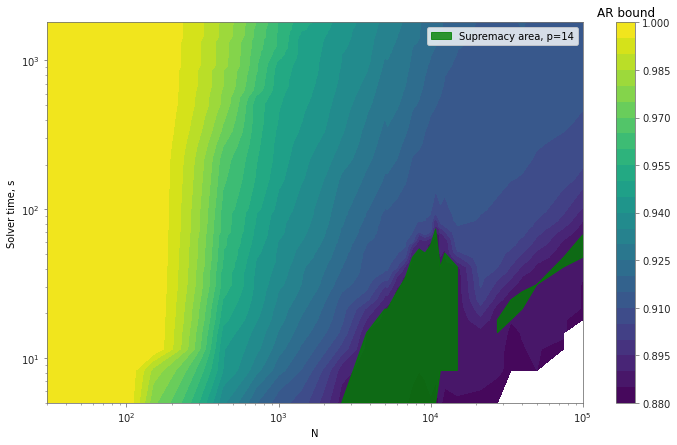

In [288]:

fig = plt.figure(figsize=(12, 7))
plt.contourf(data_match_mh.N, times, np.array(space).T, levels=25)
plt.xscale('log')
plt.yscale('log')
clb = plt.colorbar()
clb.ax.set_title('AR bound',fontsize=12)

plt.fill_between(data_match_mh.N,
                 np.array(sup_min).astype(np.float),
                 np.array(sup_max).astype(np.float),
                 alpha=.8,
                 color='green',
                 label='Supremacy area, p=14'
                )
#plt.plot(data_match_mh.N, sup_min)
#plt.plot(data_match_mh.N, sup_max)
plt.legend()
plt.xlabel('N')
plt.ylabel('Solver time, s')

In [170]:
space

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [0.966665910791628,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.

In [171]:
times

array([   3.        ,   39.67346939,   76.34693878,  113.02040816,
        149.69387755,  186.36734694,  223.04081633,  259.71428571,
        296.3877551 ,  333.06122449,  369.73469388,  406.40816327,
        443.08163265,  479.75510204,  516.42857143,  553.10204082,
        589.7755102 ,  626.44897959,  663.12244898,  699.79591837,
        736.46938776,  773.14285714,  809.81632653,  846.48979592,
        883.16326531,  919.83673469,  956.51020408,  993.18367347,
       1029.85714286, 1066.53061224, 1103.20408163, 1139.87755102,
       1176.55102041, 1213.2244898 , 1249.89795918, 1286.57142857,
       1323.24489796, 1359.91836735, 1396.59183673, 1433.26530612,
       1469.93877551, 1506.6122449 , 1543.28571429, 1579.95918367,
       1616.63265306, 1653.30612245, 1689.97959184, 1726.65306122,
       1763.32653061, 1800.        ])

In [ ]:
{'Symmetry': 0, 'PreQLinearize': 2}

In [ ]:

ax = plt.gca()
ax.get_ylim()


In [ ]:
plt.gcf().axes



In [ ]:
1/1.068

When we run algorithm on a large graph, we don't know the optimal cost, only the cost value obtained so far.

But what we want to know is approximation ratio. 

We con get a lower bound on approximation ratio

$$
R_l = \frac{Z_l}{Z_u} = 1/(G+1)
$$
    
One of useful measures of quality of solution obtained so far is band gap - relative difference between upper and lower bound. 

If upper bound is $Z_u$ and lower bound is $Z_l$ then the gap is

$$
G = |Z_u -  Z_l|/Z_l = 1/R_l - 1
$$



1

TODO:
    1. Plot first result of gurobi cut freq vs N
    2. Plot first result of gurobi time vs N
    3. Plot cut fraction vs time for gurobi
    4. For different degrees
    5. Count number of trees